In [29]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Useful Functions

In [30]:
np.random.seed(100)

In [31]:
def draw_graph(G, colour_map, pos=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    if pos is None:
        nx.draw(G, node_color=colour_map, ax=ax, node_size=200)
    else:
        nx.draw(G, pos, node_color=colour_map, ax=ax, node_size=200)

## Xavier Initialisation

A method to initialise weights in a neural network. It generates it with the bounds (-std, std) on a matrix of size (n_in, n_out). This method is used to stop gradient exploding/vanishing issues. The Uniform Xavier Initialisation was chosen here with the general formula:
$$x = \sqrt {\frac {6}{inputs\,+\,outputs}}$$  

In [32]:
def xavier(n_out, n_in):
    std = np.sqrt(6.0 / (n_in + n_out))
    return np.random.uniform(-std, std, size=(n_out, n_in))

## Cross-Entropy Loss Calculation
Cross-Entropy Loss is a common technique used to calculate the loss in a classification problem. It is used to measure the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. Letting $y$ be the true label and $\hat{y}$ be the predicted label, the formula is:
$$L(y, \hat{y}) = -\sum_{i} y_i \log(\hat{y}_i)$$
In this case we are using the loss for each $y$ and $\hat{y}$ pair and then taking the mean of the losses later on.

In [33]:
def loss_calc(pred, labels):
    true_labels = np.argmax(labels, axis=1)
    log_neg = -np.log(pred)
    return log_neg[np.arange(pred.shape[0]), true_labels]

# DataSet - Zachary's Karate Club

The Zachary's Karate Club is a social network of a university karate club, described in the paper "An Information Flow Model for Conflict and Fission in Small Groups" by Wayne W. Zachary. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. The network is undirected ut weighted based on the interactions of the 34 members outside the karate club. The dataset is used to study the social interactions between the members and the eventual split of the club into two separate clubs.

In [34]:
G = nx.karate_club_graph()

In [35]:
nx.is_weighted(G)

True

In [36]:
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
n_nodes, n_edges

(34, 78)

In [37]:
club_attribute = nx.get_node_attributes(G,'club')

In [38]:
colouring = pd.get_dummies(club_attribute, drop_first=True).astype(float).to_numpy().flatten()

In [39]:
n_labels = 2
labels = np.eye(n_labels)[colouring.astype(int)]

In [40]:
print(colouring)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


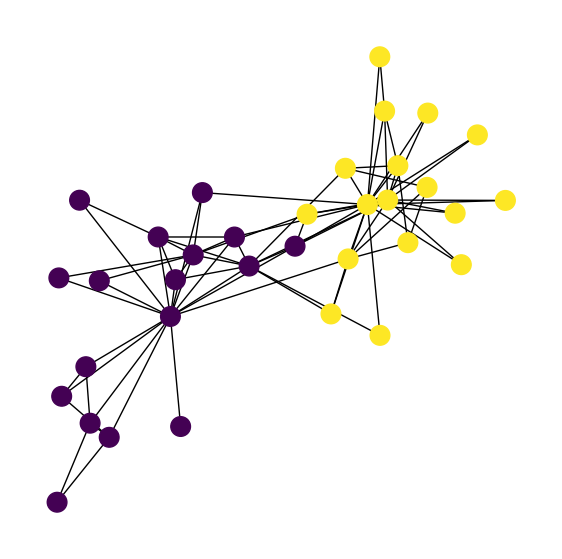

In [41]:
draw_graph(G, colouring)

# Adjacency Matrix

The adjacency matrix A is just like how a normal adjacency matrix would be, however, the weight of the edge between nodes is represented by the value in the matrix. The diagonal is filled with a self connection of weight one since a GNN also performs message passing on itself. The adjacency matrix is used to represent the graph in a matrix form and is used to calculate the normalised adjacency matrix as described in the paper <a href="https://arxiv.org/pdf/1609.02907.pdf">"Semi-Supervised Classification with Graph Convolutional Networks" by Thomas N. Kipf and Max Welling</a>

In [42]:
A = nx.to_numpy_array(G)

In [43]:
# Adding self connections
A_mod = A + np.eye(n_nodes)

D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())

D_mod_invroot = np.linalg.inv(np.sqrt(D_mod))
A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

In [44]:
#Input features, Since we dont have any node features, just start with an identity matrix
H = np.eye(n_nodes)

# Optimiser

An object that keeps track of the learning rate and weight decay. It also keeps track of the output which is the gradient that has been passed on from a previous layer when doing back propagation, predicted labels and true labels. The update method is used to update the training nodes and the number of inputs.

In [45]:
class Optimiser:
    def __init__(self, learning_rate, weight_decay, train_nodes):
        self.lr = learning_rate
        self.wd = weight_decay
        self.out = None
        self.y_pred = None
        self.y_true = None
        self.out = None
        self.train_nodes = train_nodes


# Graph Convolution Network Layer
Represents one layer of the Graph Convolution Network. It has the number of input and output features, the weights, the activation function and the name of the layer. It is divided into 2 main parts, the forward propagation and the backward propagation.

## Forward Propagation
The paper by Kipf and Welling describes the forward propagation as:
$$H^{(l+1)} = \sigma(\hat{A}H^{(l)}W^{(l)})$$
Where $\hat{A}$ is the normalised adjacency matrix, $H^{(l)}$ is the input feature matrix, $W^{(l)}$ is the weight matrix and $\sigma$ is the activation function. The forward method takes in the normalised adjacency matrix and the previous layer's output and returns the current layer's output.

## Back Propagation
Similar to the Softmax function but without the bias, the derivative of the loss with respect to the activation is calculated and then multiplied with the weights to get the gradient. The change in weights is then calculated and updated with the learning rate. TODO: Derive and write formula used.

In [46]:
class GCNLayer:
    def __init__(self, n_inputs, n_outputs, activation, name):
        #Number of input/output features
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        # Initialising weights 
        self.weights = xavier(self.n_outputs, self.n_inputs)
        # Activation function if needed, probably not gonna use it but ok
        self.act_func = activation
        # Convenient display
        self.name = name
        #Used Later
        # Normalised Adjacency Matrix A
        self.adjacency_m = None
        # Matrix to represent th message passing stage A @ H
        self.message_passing_m = None
        # H 
        self.layer_output_m = None

    #Forward propagation and message sharing among nodes
    def forward(self, A, previous_layer_output, W=None):
        # Using n as the number of nodes, f as the number of features, o as the number of outputs
        self.adjacency_m = A  # (n, n) 
        self.message_passing_m = (self.adjacency_m @ previous_layer_output).T  # (n, n) @ (n, f) = (n, f).T = (f,n)
        #Transposed to match multiplication with the weights.

        if W is None:
            W = self.weights

        self.layer_output_m = W @ self.message_passing_m # (o, f) @ (f , n) = (o, n)
        self.layer_output_m = self.act_func(self.layer_output_m)
        return self.layer_output_m.T #(o, n).T = (n, o)

    # Backwards propagation, correcting for loss.
    def backward(self, optimiser: Optimiser):
        d_tanh = 1 - np.asarray(self.layer_output_m.T) ** 2
        d2 = np.multiply(d_tanh, optimiser.out)

        gradient = self.adjacency_m @ d2 @ self.weights
        optimiser.out = gradient

        #Same as SoftMax Layer without bias
        dW = (d2.T @ self.message_passing_m.T)
        dW_wd = self.weights * optimiser.wd

        #Updating W
        self.weights -= (dW + dW_wd) * optimiser.lr



# SoftMax Layer

The SoftMax Layer hear is designed to be the last layer in the neural network. It normalises the output values down to probabilities with the softmax() function. The softmax function here is implemented has been implemented for a matrix.


## Forward Propagation
In the forward propagation step, there is no need for message passing anymore at this layer so it simply multiplies the input with the weights and adds the bias. The output is then passed through the softmax function.

## Back Propagation  
As the last layer in the Neural Network, it first differentiates the training from test nodes since all of them are included in one adjacency matrix. This allows the weights and biases to only be changed with respect to the training nodes. The derivative of the loss with respect to the activation is calculated and then multiplied with the weights to get the gradient. The change in weights and biases is then calculated and updated with the learning rate. TODO: Derive and write formula used.

In [47]:
class SoftmaxLayer:
    def __init__(self, n_inputs, n_outputs, name):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = xavier(self.n_outputs, self.n_inputs)
        self.bias = np.zeros(shape=(self.n_outputs, 1))
        self.name = name
        self.input_feature_m = None  # Used to calculate gradients

    def softmax(self, input):
        s = np.max(input, axis=1)
        s = s[:, np.newaxis]  # necessary step to do broadcasting
        e_x = np.exp(input - s)
        div = np.sum(e_x, axis=1)
        div = div[:, np.newaxis]
        return e_x / div

    def forward(self, input_feature_m, W=None, bias=None):
        #Similar to GCN Layer, just without the message passing
        self.input_feature_m = input_feature_m.T # (n, f) -> (f, n)
        if W is None:
            W = self.W
        if bias is None:
            bias = self.bias

        final_layer_out = np.asarray(W @ self.input_feature_m) + bias # (o, f) @ (f, n) = (o, n)
        return self.softmax(final_layer_out.T) # (o, n).T = (n, o)
    

    def backward(self, optimiser: Optimiser):
        # Build mask on loss, only use the nodes in training
        train_mask = np.zeros(optimiser.y_pred.shape[0])
        train_mask[optimiser.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))

        # derivative of loss w.r.t. activation (pre-softmax)
        d1 = np.asarray((optimiser.y_pred - optimiser.y_true))
        d1 = np.multiply(d1, train_mask) #(34, 2)

        #Create gradient by multiplying difference with weights
        gradient = d1 @ self.W #(34, 2) @ (2, 16) = (34, 16)
        optimiser.out = gradient

        #Calculate change in W matrix and b for the softmax layer
        #Change in learnable weights
        dW = (d1.T @ self.input_feature_m.T)
        #(2, 34) @ (34, 16) = (2, 16)
        #Change in bias
        db = d1.T.sum(axis=1, keepdims=True)
        #Change due to weight decay, L2 Regularization
        dW_wd = self.W * optimiser.wd

        # Updating Weights and biases * learning rate
        self.W -= (dW + dW_wd) * optimiser.lr
        self.bias -= db.reshape(self.bias.shape) * optimiser.lr


# Graph Convolution Neural Network

The GCN Network is built here with GCN layers and a Softmax layer. The forward method is used to calculate the output of the network and the embedding method is used to calculate the output of the network without the softmax layer. This is useful for visualisation purposes.

In [48]:
class GCNNetwork:
    def __init__(self, n_inputs, n_outputs, hidden_sizes, activation):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = len(hidden_sizes)
        self.hidden_sizes = hidden_sizes
        self.activation = activation

        self.layers = []
        # Input layer
        # GCNLayer(n_inputs, n_outputs, activation, name)
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], activation, name='in')
        self.layers.append(gcn_in)

        # Hidden layers
        for layer in range(self.n_layers):
            if layer == 0:
                gcn = GCNLayer(hidden_sizes[layer], hidden_sizes[layer], activation, name=f'h{layer}')
            else:
                gcn = GCNLayer(hidden_sizes[layer - 1], hidden_sizes[layer], activation, name=f'h{layer}')
            self.layers.append(gcn)

        # Output layer
        sm_out = SoftmaxLayer(hidden_sizes[-1], n_outputs, name='sm')
        self.output_layer = sm_out

    def embedding(self, A, H):
        # Loop through all GCN layers
        layer_output = H
        for layer in self.layers:
            layer_output = layer.forward(A, layer_output)
        return np.asarray(layer_output)

    def forward(self, A, H):
        # GCN layers
        embedding = self.embedding(A, H)
        # Softmax
        final_output = self.output_layer.forward(embedding)
        return embedding, np.asarray(final_output)

# Training

In [49]:
gcn_model = GCNNetwork(
    n_inputs=n_nodes,
    n_outputs=n_labels,
    hidden_sizes=[16, 2],
    activation=np.tanh,
)

In [50]:
np.random.seed(100)
# train_nodes = np.random.randint(n_nodes, size=10)
train_nodes = np.array([0, 1, 32, 33])
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
#Optimiser(learning_rate, weight_decay)
opt = Optimiser(2e-2, 2.5e-2, train_nodes)

In [51]:
embeddings = []
accuracy = []
train_losses = []
test_losses = []

n_iters = 500
loss_min = 1e6
es_iters = 0
es_steps = 50

for iter in range(n_iters):

    #Forward Propagation
    embedding, y_pred = gcn_model.forward(A_hat, H)
    embeddings.append(embedding)

    opt.y_pred = y_pred
    opt.y_true = labels

    #Back Propagation
    gcn_model.output_layer.backward(opt)
    for layer in reversed(gcn_model.layers):
        layer.backward(opt)

    # Accuracy for non-training nodes
    predicted_label = np.argmax(y_pred, axis=1)
    actual_label = np.argmax(labels, axis=1)
    acc = (predicted_label == actual_label)[test_nodes]
    accuracy.append(acc.mean())

    #Cross-Entropy Loss Calculation
    loss = loss_calc(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()

    train_losses.append(loss_train)
    test_losses.append(loss_test)

    #Checking to see if the model has gone a significant number of iterations without improving
    if loss_test < loss_min:
        loss_min = loss_test
        es_iters = 0
    else:
        es_iters += 1

    if es_iters > es_steps:
        print("Early stopping!")
        break

    if iter % 100 == 0:
        print(f"iter: {iter + 1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")

train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

iter: 1, Train Loss: 0.738, Test Loss: 0.710
iter: 101, Train Loss: 0.103, Test Loss: 0.273
iter: 201, Train Loss: 0.031, Test Loss: 0.153
iter: 301, Train Loss: 0.020, Test Loss: 0.128
iter: 401, Train Loss: 0.016, Test Loss: 0.119


# Results

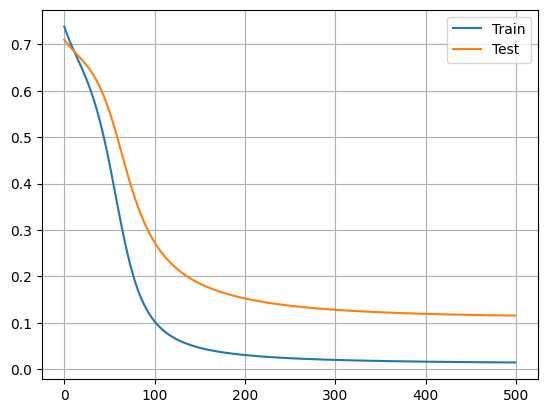

In [52]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(test_losses, label='Test')
ax.legend()
ax.grid()

In [53]:
print("Final Accuracy:", accuracy[-1])

Final Accuracy: 0.9666666666666667


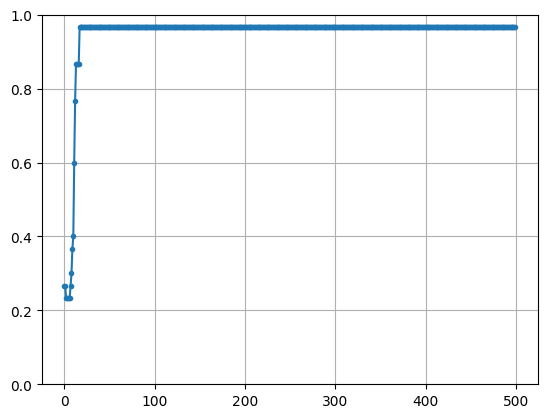

In [54]:
fig, ax = plt.subplots()
_ = ax.plot(accuracy, marker='.')
ax.grid()
_ = ax.set(ylim=[0, 1])

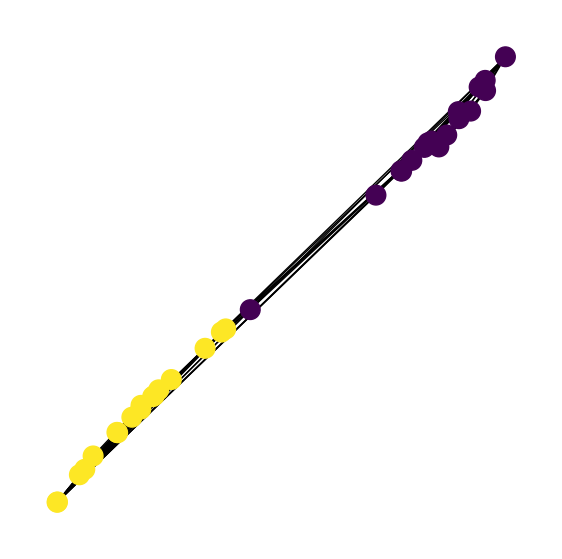

In [55]:
pos = {i: embeddings[-1][i, :] for i in range(embeddings[-1].shape[0])}
draw_graph(G, colouring, pos)

In [56]:
print(embeddings[-1])

[[ 0.89123941  0.79658729]
 [ 0.81115134  0.71189138]
 [ 0.57039133  0.47148781]
 [ 0.78724474  0.6880428 ]
 [ 0.70703656  0.57442794]
 [ 0.81260899  0.67530453]
 [ 0.75329819  0.60169144]
 [ 0.70482932  0.59975684]
 [-0.11879152 -0.11059392]
 [-0.21599746 -0.17972529]
 [ 0.65893171  0.51596319]
 [ 0.48034255  0.38626871]
 [ 0.58459811  0.48779962]
 [ 0.5993019   0.49418418]
 [-0.50515196 -0.42267735]
 [-0.55230679 -0.46754725]
 [ 0.62770672  0.47314827]
 [ 0.47782962  0.38751821]
 [-0.43130786 -0.36126966]
 [ 0.37869127  0.30019399]
 [-0.48118165 -0.398187  ]
 [ 0.5206857   0.42500325]
 [-0.4979237  -0.41774788]
 [-0.79519319 -0.70295538]
 [-0.55126678 -0.45387648]
 [-0.74087487 -0.63544869]
 [-0.64664349 -0.55083486]
 [-0.58749294 -0.49652913]
 [-0.23308757 -0.19100979]
 [-0.773947   -0.6834086 ]
 [-0.29767208 -0.24927858]
 [-0.64389193 -0.55218853]
 [-0.88361272 -0.80143675]
 [-0.88219104 -0.80063328]]
